# Estimating water consumption of irrigated agriculture in the Limpopo River Basin (LRB)

* **Products used:**
[irrigated_areas_limpopo](https://odc-explorer.digitaltwins.demos-only.iwmi.org/products/irrigated_areas_limpopo),
[WaPOR](https://data.apps.fao.org/wapor/?lang=en)


## Background

### Digital Twin (DT)
The CGIAR Digital Twin initiative creates dynamic virtual models that combine real-time data, AI, and simulations to improve decision-making. Its prototype for the Limpopo River Basin focuses on enhancing water resource management and conservation.

### Description

The Limpopo River Basin, spanning four countries in southern Africa, at times faces extreme water scarcity. For communities that rely on agriculture in the basin, the efficient use of water is essential. One of our key projects in CGIAR involves developing a [Digital Twin (DT)](https://www.iwmi.org/blogs/can-digital-twins-help-river-basin-management-in-developing-countries/) of the Limpopo River Basin to support better decision-making for managing water in the region. A digital twin is a virtual representation of a physical object or system. The CGIAR Digital Twin initiative creates dynamic virtual models that combine real-time data, AI, and simulations to improve decision-making.   A crucial component of this digital twin is tracking irrigated areas using publicly available satellite data to understand in near real-time where water is being used, how much is being used, and how these patterns change over time. More details on the method developed for mapping irrigated agriculture in the LRB and its water consumption can be found here: https://hdl.handle.net/10568/155296

This notebook describes how to calculate area covered by irrigated agriculture and subsequently estimate its water consumption for a specific region within the LRB following the steps below:

1. Select aN area of interest within the LRB.
2. Download and load irrigated area, Actual EvapoTranspiration and Interception (National - Annual - 100m) (L2-AETI-M) product of WaPOR datasets.
3. Reproject the two data.
4. Polygonize the irrigated area data and extract mean ET (L2-AETI-M) value for each polygon.
3. Calculate water consumption by getting the sum of all the mean values.

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
In this step, we import the Python packages that will be used throughout the analysis.  

In [1]:
%matplotlib inline

import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray as rio
import datacube
import pystac_client
import xvec

from odc.stac import configure_rio, stac_load
from datacube.utils.masking import mask_invalid_data
from deafrica_tools.plotting import display_map
from deafrica_tools.load_wapor import get_all_WaPORv3_mapsets, load_wapor_ds
from deafrica_tools.spatial import xr_vectorize, xr_rasterize
from wapordl import wapor_map
from osgeo import gdalnumeric, gdal

INFO: WaPORDL (`1.0.2`)


In [2]:
print(xr.__version__)

2025.9.0


### Set options for connecting to AWS



IWMI data is stored on S3 in Cape Town, South Africa. To load the data, we must configure rasterio with the appropriate AWS S3 endpoint. This can be done with the odc.stac.configure_rio function. Documentation for this function is available at   [https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.configure_rio.html#odc.stac.configure_ri]

In [3]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

### Analysis parameters



This analysis requires data about the location (lat, lon) and the desired time period to begin. Additionally, the user can adjust the buffer if necessary, which may help increase or decrease the area of interest.

In [4]:
lat, lon = -24.5726, 27.2373  #enter the latitude and longitude of your location within the Limpopo River Basin
buffer = 0.01  #how big the area around your location
start_date = "2024-06-01"  # Set your own start date
end_date = "2024-06-30"  # Set your own end date

### Select location
The study area, or bounding box, is defined by a central latitude and longitude coordinate pair (central_lat, central_lon) and a buffer distance applied in all directions from the center. Together, these parameters specify a square study area.

In [5]:
#join lat, lon, buffer to get bounding box
lon_range = (lon - buffer, lon + buffer)
lat_range = (lat + buffer, lat - buffer)

bbox = [lon_range[0], lat_range[0], lon_range[1], lat_range[1]]

# Visualise selected location
display_map(lon_range, lat_range)

### Download and load irrigated area and WaPOR data

####  Download and Load Irrigated Area Data  

In this step, we will connect to the **IWMI STAC API**-https://odc-explorer.digitaltwins.demos-only.iwmi.org/stac and retrieve the required dataset.  

- The **STAC catalog URL** points to IWMI’s data repository. You can also open this link in your browser to explore the available datasets interactively.  
- The **collections** parameter specifies the product name — in this case we download `"irrigated_areas_limpopo"`.  
- The **query** defines what subset of the data we want, using a bounding box (`bbox`) and a time range (`start_date` / `end_date`).  
- Finally, the **items** returned from the catalog represent the datasets that match our search.  

The output of this cell should be the **list of STAC items** that match the query, which we will use in the following steps.


This step will connect to IWMI stac API. The collections will specify the product name that is required to be downloaded. stac.load() requires the product name, crs and bounding box details. by default the crs is  WGS84/EPSG:4326. If the coordinates are in a different coordinate system, the crs parameter can be changed.

In [6]:
# Set the URL of the STAC catalog you wish to query
url = 'https://odc-explorer.digitaltwins.demos-only.iwmi.org/stac' ## follow this link to explore catalog

# Initialize a STAC client to interact with the specified STAC catalog
catalog = pystac_client.Client.open(url)

# Specify the collections to retrieve
collections = ['irrigated_areas_limpopo']

# Build a query with the previously set parameters to search the STAC catalog
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Fetch the items
items = list(query.items())

items   #make an item is output

[<Item id=7f5e6cb1-e474-4100-a4bb-9a67c85de55b>]

#### Load Data Using `stac_load()`  

In this step, we load the data from the STAC items retrieved earlier.  

- The **`stac_load()`** function requires:  
  - The **product name/items** (which we obtained from the STAC catalog).  
  - The **CRS (Coordinate Reference System)** – by default, this is `WGS84 / EPSG:4326`.  
  - The **bounding box (bbox)** – to define the spatial area of interest.  
- If your coordinates are in a different projection or coordinate system, you can change the `crs` parameter accordingly.  


In [7]:
# Load the irrigated area for specified parameter values

crs = "EPSG:4326"# can be changed if needed

ds = stac_load(
    items,
    crs=crs,
    chunks={},
    bbox=bbox,
)

ds

<xarray.Dataset> Size: 606kB
Dimensions:      (latitude: 224, longitude: 224, time: 1)
Coordinates:
  * latitude     (latitude) float64 2kB -24.56 -24.56 -24.56 ... -24.58 -24.58
  * longitude    (longitude) float64 2kB 27.23 27.23 27.23 ... 27.25 27.25 27.25
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 8B 2024-06-30
Data variables:
    map          (time, latitude, longitude) float32 201kB dask.array<chunksize=(1, 224, 224), meta=np.ndarray>
    prob         (time, latitude, longitude) float32 201kB dask.array<chunksize=(1, 224, 224), meta=np.ndarray>
    filtered     (time, latitude, longitude) float32 201kB dask.array<chunksize=(1, 224, 224), meta=np.ndarray>

#### Visualizing the irrigated area
The irrigated area is visualized, but user can also choose `"filtered"` or `"prob"` instead `"map"`  depending on your analysis needs.  

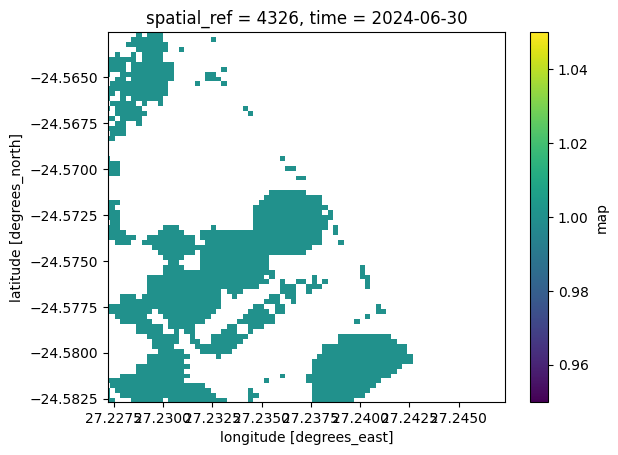

In [8]:
### Visualize irrigated areas for a single date
ds['map'].sel(time= end_date, method='nearest').compute().plot() # we chose here the "map" measurement. Other measurements include "filtered" and "prob"

#### Download irrigated area data
In this step, the irrigated area data for the selected date is extracted and saved as a **GeoTIFF file**.  

- First,  select the dataset (`map` measurement) for the specified time (`end_date`).  
- Then, use **`rio.to_raster()`** to export the data as a `.tif` file, which can be used in any GIS software for further analysis.  

The output file will be saved in the current working directory with the name format:  
`irrigated_<date>.tif`

In [9]:
### Download irrigated area data
irr_dataset = ds['map'].sel(time= end_date, method='nearest').compute()   ## Set your own data
irr_dataset.rio.to_raster(os.getcwd() + "/" + "irrigated_" + end_date + ".tif")

#### Calculation of irrigated area
This function calculates the total irrigated area (in hectares) between two dates using the classified raster file downloaded above. It loads the raster as a NumPy array, counts the number of pixels with a value of 1 (representing irrigated land), multiplies this count by the known area of a single pixel (100 m²), and converts the result to hectares by dividing by 10,000

In [10]:
### Calculate area coverage of irrigated agriculture**

area_per_pixel = 100  # area of a single pixel

raster_file = gdalnumeric.LoadFile(os.getcwd() + "/" + "irrigated_" + end_date + ".tif")
pixel_count = (raster_file == 1).sum()  ## get the sum of all the pixels

area_ha = pixel_count * area_per_pixel / 10000  ##pixel_count * area_per_pixel
print('The area of the irrigated field between {} and {} is {} ha: '.format(start_date, end_date, area_ha))

The area of the irrigated field between 2024-06-01 and 2024-06-30 is 106.58 ha: 


#### Download and load WaPOR area

WaPOR (Water Productivity through Open access of Remotely sensed derived data) is a dataset developed by FAO (Food and Agriculture Organization of the UN) to monitor water productivity, agriculture, and irrigation performance across Africa and the Near East.

Digital Earth Africa (DE Africa) provides free, analysis-ready access to WaPOR data for the African continent.In this analysis "L2-AETI-M" is used from DE Africa stac as source of wapor data.The data is downloaded in `.tiff` format for the specific region selected.

In [11]:
get_all_WaPORv3_mapsets() #Get the list of the products of Wapor. For water water consumption, we are going to use L2-AETI-M

,Mapset Code,Mapset Description
0,L1-AETI-A,Actual EvapoTranspiration and Interception (Gl...
1,L1-AETI-D,Actual EvapoTranspiration and Interception (Gl...
2,L1-AETI-M,Actual EvapoTranspiration and Interception (Gl...
3,L1-E-A,Evaporation (Global - Annual - 300m)
4,L1-E-D,Evaporation (Global - Dekadal - 300m)
5,L1-GBWP-A,Gross biomass water productivity (Annual - 300m)
6,L1-I-A,Interception (Global - Annual - 300m)
7,L1-I-D,Interception (Global - Dekadal - 300m)
8,L1-NBWP-A,Net biomass water productivity (Annual - 300m)
9,L1-NPP-D,Net Primary Production (Global - Dekadal - 300m)


#### Set Parameters for Downloading WAPOR Data  

Before downloading WAPOR data, we need to define a few key parameters:  

- **`region`**: Defines the spatial area of interest using coordinates `[min_lon, max_lat, max_lon, min_lat]`.  
- **`folder`**: Directory where the downloaded data will be saved. By default, it is set to the **current working directory**, but you can change it to any folder you prefer.  
- **`variable`**: The WAPOR product to download. Here we use `"L2-AETI-M"` (monthly actual evapotranspiration).  
- **`period`**: The time range for which data will be loaded, specified as `[start_date, end_date]`.  



In [ ]:
# Set argument values for the downloading wapor data
region =  [lon_range[0], lat_range[1], lon_range[1], lat_range[0]]
folder = os.getcwd() # stored in current wonking directory. Change to your own directory
variable = "L2-AETI-M" # Product
period = [start_date, end_date] # period to load

# Download the WaPOR for specified paramater values
aeti = wapor_map(region, variable, period, folder, extension = '.tif')
# Open the dataset with rioxarray to enable geospatial operations
aeti = rio.open_rasterio("bb_L2-AETI-M_NONE_none.tif")
# load the WaPor data
aeti

INFO: Found 1 files for L2-AETI-M.

#### Visualize WAPOR Data  

In this step, the WAPOR data for the selected region and period is visualized.

In [ ]:
# Visualize the wapor data
aeti.plot()

### Reproject wapor data to the match the spatial resolution of the irrigated area data

This step will verify if irrigated and wapor data have the same projection, if not reprojection will be done followed by resampling and null data removal. 

In [ ]:
## Verify if irrigated and wapor data have the same projection
aeti.geobox == irr_dataset.geobox

#### Reproject WAPOR Data  

In this step, reproject the WAPOR data to match the **spatial resolution and grid** of the irrigated area dataset (`irr_dataset`).  

- **`reproject()`** aligns the WAPOR data to the same geobox as the irrigated area data. `resampling="average"` is used to aggregate values when the grids do not perfectly match.  
- **`mask_invalid_data()`** replaces invalid or missing values (e.g., nodata) with `NaN`, ensuring that analyses like overlays or calculations do not get affected by invalid data points.  



In [ ]:
# Reproject data
aeti_reprojected = aeti.odc.reproject(how=irr_dataset.odc.geobox, resampling="average")
# Set nodata to `NaN`
aeti_reprojected = mask_invalid_data(aeti_reprojected)
## Verify again if irrigated and wapor data have the same projection
aeti_reprojected.geobox == irr_dataset.geobox

### Polygonize the irrigated area data and extract mean ET value for each polygon

This code identifies irrigated areas from a raster dataset by selecting pixels with a value of 1, then converts these irrigated pixels into vector polygons using xr_vectorize. Next, it computes the mean Actual Evapotranspiration (ET) for each polygon from a reprojected ET raster (aeti_reprojected) using zonal statistics based on latitude and longitude coordinates.

The resulting ET values are extracted and stored in a pandas DataFrame (df_et), where each row represents a polygon along with its corresponding mean ET value. This workflow is useful for evaluating water use in irrigated regions and enables spatial analysis of evapotranspiration patterns using datasets such as WaPOR.

In [ ]:
#Polygonize irrigated areas
gdf = xr_vectorize(irr_dataset,
                  mask= irr_dataset.values==1)
gdf.head()

### Extract Mean ET Values for Each Polygon  

In this step, the **mean evapotranspiration (ET)** is calculate for each polygon in the study area.


In [ ]:
# extract mean ET value for each polygon
et_extracted = aeti_reprojected.xvec.zonal_stats(gdf.geometry, "longitude", "latitude")  # "mean" is the default spatial aggregation statistic method
df_et = pd.DataFrame(et_extracted.values, columns=['mean_et']) #Convert the resulting DataArray to dataframe
df_et.head()

### Calculate water consumption for the whole irrigated area

- **`mean_et`**: Represents the mean evapotranspiration value per polygon in millimeters (mm).

- **`0.1`**: A scale factor used to correct or normalize the ET values if they were originally scaled (common in satellite datasets).

- **`0.001`** :  Converts millimeters (mm) to meters (m).

- **`100`** : Represents the pixel area in square meters (m²) — likely assuming each pixel is 10m x 10m (100 m²).

The result is an estimate of water volume (in m³) consumed by evapotranspiration in each polygon.



In [ ]:
## Add a column, multiply each row value with scale factor (0.1), then by 0.001 (to convert m3), then by the pixel area (100), and sum all the row values to get the total ET value of the whole irrigated area
df_et['water_consumption'] = df_et['mean_et'] * 0.1 * 0.001 * 100
sum_et = df_et['water_consumption'].sum()

print('The water consumption of the irrigated field between {} and {} is : {} m3'.format(start_date, end_date, sum_et))

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

## References

1.   Garcia Andarcia, M., Dickens, C., Silva, P., Matheswaran, K., & Koo, J. (2024). Digital Twin for management of water resources in the Limpopo River Basin: a concept. Colombo, Sri Lanka: International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation. 4p.
2.   Afham, Abdul; Silva, Paulo; Ghosh, Surajit; Kiala, Zolo; Retief, H.; Dickens, Chris; Garcia Andarcia, Mariangel. 2024. Limpopo River Basin Digital Twin Open Data Cube Catalog. Colombo, Sri Lanka: International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation. 22p.
3.   Kiala, Zolo; Matheswaran, Karthikeyan. 2024. Status of irrigated area in the Limpopo River Basin: July 2024. Colombo, Sri Lanka: International Water Management Institute (IWMI). CGIAR Initiative on Digital Innovation. 5p.

In [ ]:
print(datacube.__version__)

**Contributors**

Zolo Kiala <br>
Postdoc researcher <br>
Email: z.kiala@cgiar.org <br>

<br>

Kayathri Vigneswaran <br>
Junior Data Scientist <br>
Email: v.kayathri@cgiar.org <br>

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')